In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikes4 as spk4
import snn_models

In [2]:
#%% Parameters
time_step = 1 # 1ms time resolution

lr = 0.002 # learning rate 0.005
thr = 0.6 #0.6 # v threshold
tau_out = 1 # output decay time constant /// unit: ms
kappa = np.exp(-time_step/tau_out) # output decay
tau_mem = 20 # v decay time constant /// unit: ms
alpha = np.exp(-time_step/tau_mem) # v decay
beta = 0.2 # adaptation increment 
tau_a = 200 # adaptation decay time constant /// unit: ms
rho = np.exp(-time_step/(tau_a+1e-12)) # adaptation decay
t_ref = 2 # refractory period /// unit: ms
c_reg = 20
f_target = 10*(1e-3) #10*(1e-3) # 10 Hz = 10*(1e-3) 1/ms
params = np.array([lr, thr, alpha, beta, kappa, rho, t_ref, c_reg, f_target]) # save as a vector

In [3]:
with open('spike_data95_fr_matched.npy','rb') as f:
    spike_data = np.load(f)
with open('linear_interpolated_y95.npy','rb') as g:
    linear_interpolated_y = np.load(g)

In [4]:
# Divide data in batches
nb_batch = 10 # number of batches
nb_inputs, nb_hidden, nb_outputs  = 95, 100, 4  # set nb_outputs to 4 just for this part

nb_tstep = int(spike_data.shape[0]/nb_batch)
x = np.zeros((nb_batch, nb_tstep, nb_inputs))
y = np.zeros((nb_batch, nb_tstep, nb_outputs))
for b in range(nb_batch):
        x[b,:,:] = spike_data[nb_tstep*b:nb_tstep*(b+1),:]
        y[b,:,:] = linear_interpolated_y[nb_tstep*b:nb_tstep*(b+1),:]

# Normalization
y = y/ np.max(np.abs(y))
print(x.shape)          # 10 batches, each batch contains 314130 ms long data, 95 channel
print(y.shape)  

(10, 314130, 95)
(10, 314130, 4)


In [5]:
# 1 output case
nb_inputs, nb_hidden, nb_outputs = 95, 100, 1
y = y[:,:,0:1]

In [6]:
#%% initialize weight
weight_scale = 10*(1.0-alpha) #!!!
w1 = np.random.normal(size=(nb_inputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_inputs)) # input-->hidden
w2 = np.random.normal(size=(nb_hidden,nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->hidden
#bias = np.random.normal(size=(nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) # output bias
bias = np.zeros(nb_outputs) # output bias
B = np.random.normal(size=(nb_outputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) #!!! random e-prop

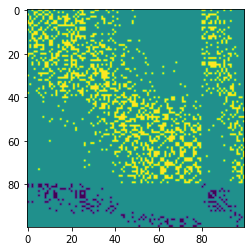

In [7]:
#%% recurrent weights (choose only one)
############### (1) random network ###############
#wr = np.random.normal(size=(nb_hidden,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->output
#np.fill_diagonal(wr,0) # no self connectivity

############### (2) E/I network ###############
import graph_analysis
nb_e = int(nb_hidden*0.8)
nb_i = nb_hidden - nb_e
ind_fromi = np.zeros((nb_hidden,nb_hidden),dtype=bool)
ind_fromi[nb_e:,:] = True # index of inhibitory neurons

wr, xy, cdens = graph_analysis.aij_distance2d([1000,1000], [250,150], nb_e, nb_i, np.array([[1,-1],[1,-1]]), cself=False, plot=False, randomseed=None)
wr = wr.T
wr *= 0.05 # scaling

plt.imshow(wr) # visualize initial weights

In [8]:
# run it with smaller data set (here, reduce the number of timestep)
# 1 output case
x = x[:,0:int(100000),:]      # ~30% of the data used  
y = y[:,0:int(100000),0:1] 

# 4 output case
#x = x[:,0:int(31413*5),:]
#y = y[:,0:int(31413*5),:]

In [9]:
#%% run train
nb_inputs, nb_hidden, nb_outputs= 95, 100, 1

dw1_past = np.zeros((nb_inputs,nb_hidden))
dw2_past = np.zeros((nb_hidden,nb_outputs))
dwr_past = np.zeros((nb_hidden,nb_hidden))
dbias_past = np.zeros((nb_outputs,))
loss_train, fr_train, acc_train, spktr, wrs, atr = [],[],[],[],[],[]
loss_valid, fr_valid, acc_valid = [],[],[]
n_epochs = 10

for epoch in range(n_epochs): 
    ######################### train #########################
    for batch_idx in range(nb_batch-1):
        x_train, y_train = x[batch_idx,:,:].copy(),y[batch_idx,:,0:1].copy()
        loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop6(w1,wr,w2,bias,B,x_train,y_train,params)
    
        dw1_past = 0.9*dw1_past + dw1[0] #!!! momentum=0.9
        dw2_past = 0.9*dw2_past + dw2[0] #!!! momentum=0.9
        dwr_past = 0.9*dwr_past + dwr[0] #!!! momentum=0.9
        dbias_past = 0.9*dbias_past + dbias[0] #!!! momentum=0.9
        
        w1 += dw1_past # input-->hidden update
        w2 += dw2_past # hidden-->hidden update
        wr += dwr_past # hidden-->output update
        bias += dbias_past # bias update 
        
#        print("loss=", loss)
#     w1 += np.mean(dw1,0) # these are for no-momentum update (slow learning)
#     w2 += np.mean(dw2,0)
#     wr += np.mean(dwr,0)
#     bias += np.mean(dbias,0)
#     np.fill_diagonal(wr,0) # no-self connectivity

#    dwr[0] -= (1e-2)*np.linalg.norm(dwr[0])
#    dw1[0] -= (1e-2)*np.linalg.norm(dw1[0])  
#    dw2[0] -= (1e-2)*np.linalg.norm(dw2[0])    
            
#    w1 += dw1[0] # these are for no-momentum update (slow learning)
#    w2 += dw2[0]
#    wr += dwr[0]
#    bias += dbias[0]
#    np.fill_diagonal(wr,0) # no-self connectivity
    
#    print(np.linalg.norm(dw2))
#    print("dwr=", dwr)
        #!!! below 5 lines are valid only for E/I network (uncomment when using random network) 
        ind_negative = wr<0
        ind = ind_negative*(~ind_fromi) # find negative & exciatory neurons
        wr[ind] = 0. # force the negative weights to 0
        ind = (~ind_negative)*ind_fromi # find positive & inhibitory neurons
        wr[ind] = 0. # force the positive weights to 0
        
    loss_train.append(loss.mean()) # save loss 
    fr_train.append(1000*z_rec.mean()) # save firing rate
    print('EPOCH %d TRAIN) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_train[epoch], fr_train[epoch]))

    ######################### validate #########################
    x_valid,y_valid = x[-1,:,:].copy(),y[-1,:,0:1].copy() # last batch for validation
    loss_batch, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop6(w1,wr,w2,bias,B,x_valid,y_valid,params)
    
    loss_valid.append(loss_batch.mean()) # save loss
    fr_valid.append(1000*z_rec.mean()) # save firing rate
    print('EPOCH %d VALID) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_valid[epoch], fr_valid[epoch]))
        
    spktr.append(z_rec[0]) # save spike train /// save one batch data only to save memory
    atr.append(a_rec[0]) # save a trace
    wrs.append(wr.copy()) # save weights
    
    ######################### save best weights #########################
    if loss_valid[-1] == min(loss_valid): # or you can use acc criteria instead
        w1_save,w2_save,wr_save,bias_save = w1.copy(),w2.copy(),wr.copy(),bias.copy()
        epoch_best = epoch
spktr = np.stack(spktr,0)
atr = np.stack(atr,0)
wrs = np.stack(wrs,0)
N = int(n_epochs/8) # epoch interval for plotting

EPOCH 0 TRAIN) loss: 1.8170, fr: 1.2364 Hz
EPOCH 0 VALID) loss: 1.5216, fr: 1.2410 Hz
EPOCH 1 TRAIN) loss: 0.6992, fr: 1.4988 Hz
EPOCH 1 VALID) loss: 0.9821, fr: 1.5261 Hz
EPOCH 2 TRAIN) loss: 0.7133, fr: 2.0619 Hz
EPOCH 2 VALID) loss: 0.8084, fr: 2.0899 Hz
EPOCH 3 TRAIN) loss: 0.9133, fr: 2.7249 Hz
EPOCH 3 VALID) loss: 0.9992, fr: 2.7326 Hz
EPOCH 4 TRAIN) loss: 0.7962, fr: 3.3340 Hz
EPOCH 4 VALID) loss: 0.9675, fr: 3.3080 Hz
EPOCH 5 TRAIN) loss: 0.6918, fr: 3.7637 Hz
EPOCH 5 VALID) loss: 0.8245, fr: 3.7281 Hz
EPOCH 6 TRAIN) loss: 0.7542, fr: 4.2061 Hz
EPOCH 6 VALID) loss: 0.8294, fr: 4.1587 Hz
EPOCH 7 TRAIN) loss: 0.7708, fr: 4.6893 Hz
EPOCH 7 VALID) loss: 0.9233, fr: 4.6231 Hz
EPOCH 8 TRAIN) loss: 0.6797, fr: 5.0533 Hz
EPOCH 8 VALID) loss: 0.8194, fr: 4.9703 Hz
EPOCH 9 TRAIN) loss: 0.8022, fr: 5.4222 Hz
EPOCH 9 VALID) loss: 0.8895, fr: 5.3385 Hz


In [10]:
# plotting example decode with best weight
x_valid,y_valid = x[-1,:,:].copy(),y[-1,:,0:1].copy() # last batch for validation
loss_batch, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop2(w1_save,wr_save,w2_save,bias_save,B,x_valid,y_valid,params)

In [11]:
# Reduce resolution to 100ms for plotting
length = round(out_rec.shape[1]/100)

y_valid_100ms = np.zeros(length)   # y_valid with 100ms resolution
out_rec_100ms = np.zeros(length)   # out_rec with 100ms resolution
for i in range(length):
    out_rec_100ms[i] = out_rec[0,i*100,0]
    y_valid_100ms[i] = y[-1,i*100,0]

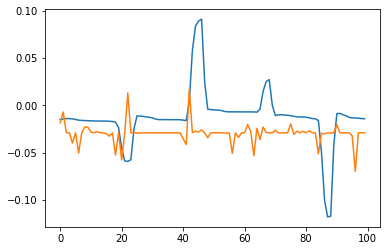

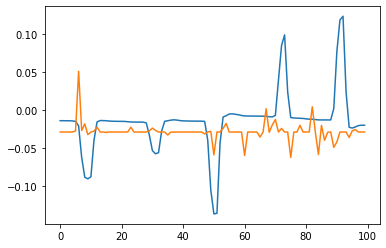

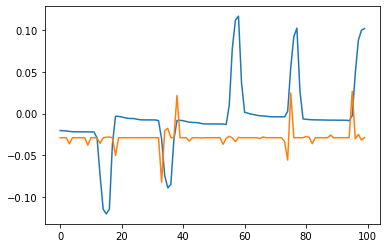

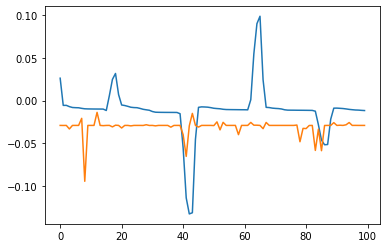

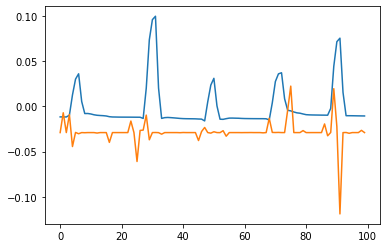

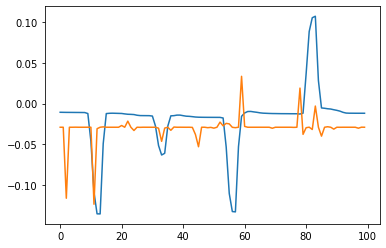

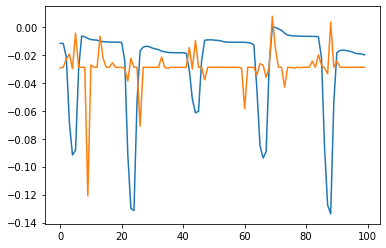

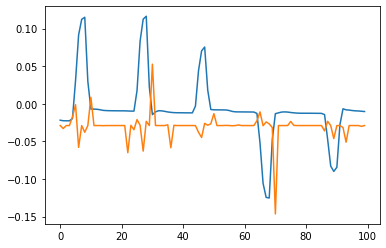

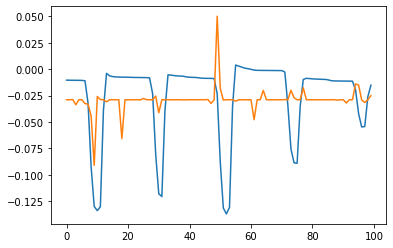

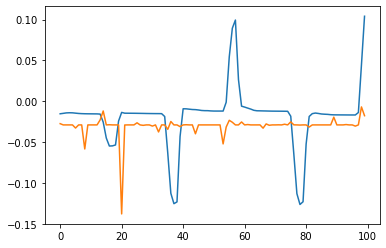

In [12]:
plt.figure()

for i in range(10):
    plt.plot(y_valid_100ms[100*i:100*(i+1)], label='actual')
    plt.plot(out_rec_100ms[100*i:100*(i+1)], label='predicted')
    plt.show()